*Important Note:* This file was submitted as part of Milestone 2 and covers data processing and baseline model implementation. It is designed to run in Colab (i.e. NOT locally).

In [ ]:
"""""""""""""""""""""""""""""""""

Description:

Running the following scripts will collect our VisDrone data and load it into
the structure outlined below:

VisDrone/
├── VisDrone2019-DET-test-dev/
│   ├── annotations/
│   └── images/
├── VisDrone2019-DET-train/
│   ├── annotations/
│   └── images/
├── VisDrone2019-DET-val/
│   ├── annotations/
│   └── images/
├── VisDrone2019-DET-test-dev.zip
├── VisDrone2019-DET-train.zip
└── VisDrone2019-DET-val.zip


"""""""""""""""""""""""""""""""""

'\n\nDescription:\n\nRunning the following scripts will collect our VisDrone data and load it into\nthe structure outlined below, primarily utilizing gdown:\n\nVisDrone/\n├── VisDrone2019-DET-test-dev/\n│   ├── annotations/\n│   └── images/\n├── VisDrone2019-DET-train/\n│   ├── annotations/\n│   └── images/\n├── VisDrone2019-DET-val/\n│   ├── annotations/\n│   └── images/\n├── VisDrone2019-DET-test-dev.zip\n├── VisDrone2019-DET-train.zip\n└── VisDrone2019-DET-val.zip\n\nWe then perform several high-level checks of paths and contents to confirm the\nexpected structure above is present in the environment.\n\n\n'

In [2]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [3]:
# Imports (for version, see requirements.txt)
import os
import torch
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms.functional as F
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import precision_score, recall_score, f1_score
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.ops import box_iou, MultiScaleRoIAlign
import torch.nn as nn
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import torch.optim as optim
import time

In [4]:
# Create Parent Directory
dataset_dir = "/content/VisDrone"
os.makedirs(dataset_dir, exist_ok=True)

In [5]:
# TESTING DATASET
# Download the file from Dropbox
!wget -O VisDrone/VisDrone2019-DET-test-dev.zip "https://www.dropbox.com/scl/fi/yuim21nvv96pdmetf43mu/VisDrone2019-DET-test-dev.zip?rlkey=m4htjb3wjdvjukshn3inh9s7d&st=ajdims0w&dl=1"

# Unzip the file
!unzip -q VisDrone/VisDrone2019-DET-test-dev.zip -d VisDrone/VisDrone2019-DET-test-dev/

--2025-04-27 19:20:01--  https://www.dropbox.com/scl/fi/yuim21nvv96pdmetf43mu/VisDrone2019-DET-test-dev.zip?rlkey=m4htjb3wjdvjukshn3inh9s7d&st=ajdims0w&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7454ec7df50784b294b45e0796.dl.dropboxusercontent.com/cd/0/inline/ConoZbOYIg7jo7rY_6-uMTAReJmtHNZ9gxO21FTZ7OKsvhTXkS6BLuPLnfOqu1AVGpRrYCJnRO_nu9QWDnH2DXMRIbwzOUT8ss8Y8KvAqUe4a8TbbtG6o0ETFPmbJI3auF2foSWJwDbozMDFGzWVLiML/file?dl=1# [following]
--2025-04-27 19:20:01--  https://uc7454ec7df50784b294b45e0796.dl.dropboxusercontent.com/cd/0/inline/ConoZbOYIg7jo7rY_6-uMTAReJmtHNZ9gxO21FTZ7OKsvhTXkS6BLuPLnfOqu1AVGpRrYCJnRO_nu9QWDnH2DXMRIbwzOUT8ss8Y8KvAqUe4a8TbbtG6o0ETFPmbJI3auF2foSWJwDbozMDFGzWVLiML/file?dl=1
Resolving uc7454ec7df50784b294b45e0796.dl.dropboxusercontent.com (uc7454ec7df50784b294b45e0796.dl.dro

In [6]:
# TRAINING DATASET
# Download the file from Dropbox
!wget -O VisDrone/VisDrone2019-DET-train.zip "https://www.dropbox.com/scl/fi/xyjppciooyq0juffv0g6y/VisDrone2019-DET-train.zip?rlkey=y5hnuo2imr1we88xzvndmkzct&st=6exf6hz8&dl=1"

# Unzip the file
!unzip -q VisDrone/VisDrone2019-DET-train.zip -d VisDrone/

--2025-04-27 19:20:13--  https://www.dropbox.com/scl/fi/xyjppciooyq0juffv0g6y/VisDrone2019-DET-train.zip?rlkey=y5hnuo2imr1we88xzvndmkzct&st=6exf6hz8&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uce679eb105fffaef9b949ed13ff.dl.dropboxusercontent.com/cd/0/inline/ComIrymyL6tEX0LGapabpDFhaPcodQ8jIOydrQgrDK1HmHEJrACNXfKb3-zx_vbeZ0twZXFbQ11JTxahO4JqucJdBW-TPb0WWf9wKRoPeWdBxzqDnweSVjhxkyuQ9u7GvE53IbyNHD5wIkJx0hxVgxG7/file?dl=1# [following]
--2025-04-27 19:20:13--  https://uce679eb105fffaef9b949ed13ff.dl.dropboxusercontent.com/cd/0/inline/ComIrymyL6tEX0LGapabpDFhaPcodQ8jIOydrQgrDK1HmHEJrACNXfKb3-zx_vbeZ0twZXFbQ11JTxahO4JqucJdBW-TPb0WWf9wKRoPeWdBxzqDnweSVjhxkyuQ9u7GvE53IbyNHD5wIkJx0hxVgxG7/file?dl=1
Resolving uce679eb105fffaef9b949ed13ff.dl.dropboxusercontent.com (uce679eb105fffaef9b949ed13ff.dl.dropbo

In [7]:
# VALIDATION DATASET
# Download the file from Dropbox
!wget -O VisDrone/VisDrone2019-DET-val.zip "https://www.dropbox.com/scl/fi/op5lfc9g1eqjx0hmz5k66/VisDrone2019-DET-val.zip?rlkey=06rpa2gcfdzw1dc8vud39bypr&st=v1ndh3zz&dl=1"

# Unzip the file
!unzip -q VisDrone/VisDrone2019-DET-val.zip -d VisDrone/

--2025-04-27 19:20:55--  https://www.dropbox.com/scl/fi/op5lfc9g1eqjx0hmz5k66/VisDrone2019-DET-val.zip?rlkey=06rpa2gcfdzw1dc8vud39bypr&st=v1ndh3zz&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf54bad6452cc4aeb9475070ac5.dl.dropboxusercontent.com/cd/0/inline/ColZuj-47aWqGE0JpT7p8svr4iieLEp6S9mtz6TuuxuVOlUl9SIgIwnW7MCL3LV0ttrwZZLV6fYCYfY7HIly9oRqM8fyebigyFZlJJ8j0VD3CNIs-jztdL8e45m15kq8cr6fZBHKA6kLNP-IRWFaHLj3/file?dl=1# [following]
--2025-04-27 19:20:56--  https://ucf54bad6452cc4aeb9475070ac5.dl.dropboxusercontent.com/cd/0/inline/ColZuj-47aWqGE0JpT7p8svr4iieLEp6S9mtz6TuuxuVOlUl9SIgIwnW7MCL3LV0ttrwZZLV6fYCYfY7HIly9oRqM8fyebigyFZlJJ8j0VD3CNIs-jztdL8e45m15kq8cr6fZBHKA6kLNP-IRWFaHLj3/file?dl=1
Resolving ucf54bad6452cc4aeb9475070ac5.dl.dropboxusercontent.com (ucf54bad6452cc4aeb9475070ac5.dl.dropboxu

In [4]:
import glob

def get_image_and_annotation_paths(image_dir, annotation_dir):
  # Use image / annotation paths to map to actual training / testing data
    image_paths = sorted(glob.glob(os.path.join(image_dir, '*.jpg')))
    annotation_paths = [
        os.path.join(annotation_dir, os.path.basename(p).replace('.jpg', '.txt'))
        for p in image_paths
    ]
    return image_paths, annotation_paths

  # Update paths for your train/val/test sets
train_image_paths, train_annotation_paths = get_image_and_annotation_paths(
    'VisDrone/VisDrone2019-DET-train/images',
    'VisDrone/VisDrone2019-DET-train/annotations'
)

val_image_paths, val_annotation_paths = get_image_and_annotation_paths(
    'VisDrone/VisDrone2019-DET-val/images',
    'VisDrone/VisDrone2019-DET-val/annotations'
)

test_image_paths, test_annotation_paths = get_image_and_annotation_paths(
    'VisDrone/VisDrone2019-DET-test-dev/images',
    'VisDrone/VisDrone2019-DET-test-dev/annotations'
)

In [ ]:
"""""""""""""""""""""""""""""""""

Description:

The next two blocks of code define a Dataset class, and then utilize that class
to create 3 instances, one for the training, validation, and testing splits.

We then use those objects to create our Dataloaders, such that our data is ready
for use in training our model.

"""""""""""""""""""""""""""""""""

In [5]:
class VisDroneDataset(Dataset):
    def __init__(self, image_paths, annotation_paths, resize_to=(640, 640), transforms=None, device='cpu'):

        self.image_paths = image_paths
        self.annotation_paths = annotation_paths

        self.resize_to = resize_to
        self.transforms = transforms
        self.device = device

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
      # Load image
      img_path = self.image_paths[idx]
      img = cv2.imread(img_path)
      # Error check to skip faulty image data
      if img is None:
          print(f"Failed to load image: {img_path}, skipping.")
          return self.__getitem__((idx + 1) % len(self))

      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, self.resize_to)
      img = torch.tensor(img / 255.0, dtype=torch.float32).permute(2, 0, 1)

      # Load annotation
      ann_path = self.annotation_paths[idx]
      boxes = []
      labels = []

      try:
          with open(ann_path, 'r') as f:
              for line in f:
                  line = line.strip()
                  if not line:
                      continue
                  try:
                      vals = list(map(int, line.split(',')))
                      x, y, w, h, cls_id = vals[0], vals[1], vals[2], vals[3], vals[5]

                      # Skip invalid boxes
                      if w <= 0 or h <= 0:
                          continue

                      x2, y2 = x + w, y + h
                      if x2 <= x or y2 <= y:
                          continue

                      # Skip invalid labels
                      if cls_id <= 0:
                          continue

                      boxes.append([x, y, x2, y2])
                      labels.append(cls_id)
                  except ValueError:
                      print(f"Skipping annotation in: {ann_path}")
                      continue
      except FileNotFoundError:
          print(f"Missing annotation file: {ann_path}, skipping.")
          return self.__getitem__((idx + 1) % len(self))

      # Skip samples with no valid annotations
      if len(boxes) == 0:
          print(f"No valid boxes in {img_path}, skipping.")
          return self.__getitem__((idx + 1) % len(self))

      boxes = torch.tensor(boxes, dtype=torch.float32)
      labels = torch.tensor(labels, dtype=torch.int64)

      target = {'boxes': boxes, 'labels': labels}
      return img, target




In [6]:
# Use the following lines when training on the full set
# train_dataset = VisDroneDataset(train_image_paths, train_annotation_paths, resize_to=(512, 512))
# val_dataset = VisDroneDataset(val_image_paths, val_annotation_paths, resize_to=(512, 512))
# test_dataset = VisDroneDataset(test_image_paths, test_annotation_paths, resize_to=(512, 512))

# For now, using these lines to limit the number of samples trained on, for exploration

full_train_dataset = VisDroneDataset(train_image_paths, train_annotation_paths, resize_to=(512, 512), device='cpu')
full_val_dataset = VisDroneDataset(val_image_paths, val_annotation_paths, resize_to=(512, 512), device='cpu')
full_test_dataset = VisDroneDataset(test_image_paths, test_annotation_paths, resize_to=(512, 512), device='cpu')

# Find valid sample indices for training dataset
valid_indices = []
for i in range(len(full_train_dataset)):
    try:
        img, target = full_train_dataset[i]
        if len(target['boxes']) > 0:
            valid_indices.append(i)
        # Break early for sample testing
        if len(valid_indices) >= 200:
            break
    except Exception:
        continue

# Use only the first 200 valid entries
train_dataset = Subset(full_train_dataset, valid_indices)

# Find valid sample indices for validation dataset
valid_indices = []
for i in range(len(full_val_dataset)):
    try:
        img, target = full_val_dataset[i]
        if len(target['boxes']) > 0:
            valid_indices.append(i)
        if len(valid_indices) >= 200:
            break
    except Exception:
        continue

# Use only the first 200 valid entries
val_dataset = Subset(full_val_dataset, valid_indices)

# Find valid sample indices for validation dataset
valid_indices = []
for i in range(len(full_test_dataset)):
    try:
        img, target = full_test_dataset[i]
        if len(target['boxes']) > 0:
            valid_indices.append(i)
        if len(valid_indices) >= 200:
            break
    except Exception:
        continue

# Use only the first 200 valid entries
test_dataset = Subset(full_test_dataset, valid_indices)

# Create dataloaders for each subset

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                                   collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(val_dataset, batch_size=4, shuffle=False,
                                    collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False,
                                    collate_fn=lambda x: tuple(zip(*x)))

In [7]:
# label map
label_map = {
    0: 'Ignored',
    1: 'Pedestrian',
    2: 'Person',
    3: 'Car',
    4: 'Van',
    5: 'Bus',
    6: 'Truck',
    7: 'Motor',
    8: 'Bicycle',
    9: 'Awning-tricycle',
    10: 'Tricycle',
    11: 'Other'
}

In [ ]:
# BASELINE MODEL:

# Load a pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the classifier with one that matches your dataset
num_classes = len(label_map) + 1  # +1 for background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Reduce number of region proposals to improve speed
model.rpn.pre_nms_top_n_train = 1000
model.rpn.post_nms_top_n_train = 300
model.rpn.pre_nms_top_n_test = 500
model.rpn.post_nms_top_n_test = 100

In [ ]:
# Training the baseline model
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # Record epoch loss
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1} loss: {epoch_loss:.4f}")
    lr_scheduler.step()

# Validation pass
model.eval()
with torch.no_grad():
    for images, targets in valid_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)
        break

Epoch 1/5: 100%|██████████| 50/50 [00:41<00:00,  1.19it/s]


Epoch 1 loss: 1134.0580


Epoch 2/5: 100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


Epoch 2 loss: 1020.7414


Epoch 3/5: 100%|██████████| 50/50 [00:40<00:00,  1.22it/s]


Epoch 3 loss: 984.5111


Epoch 4/5: 100%|██████████| 50/50 [00:40<00:00,  1.22it/s]


Epoch 4 loss: 963.4196


Epoch 5/5: 100%|██████████| 50/50 [00:40<00:00,  1.22it/s]


Epoch 5 loss: 937.5511


Prediction Summary:
  Total predictions: 100
  Scores: tensor([0.1231, 0.1149, 0.1069, 0.1044, 0.0997, 0.0968, 0.0967, 0.0961, 0.0956,
        0.0948, 0.0933, 0.0889, 0.0888, 0.0874, 0.0845, 0.0832, 0.0822, 0.0774,
        0.0760, 0.0758, 0.0757, 0.0749, 0.0743, 0.0741, 0.0737, 0.0731, 0.0726,
        0.0726, 0.0725, 0.0719, 0.0719, 0.0718, 0.0709, 0.0704, 0.0701, 0.0699,
        0.0699, 0.0697, 0.0696, 0.0687, 0.0681, 0.0679, 0.0677, 0.0671, 0.0669,
        0.0666, 0.0665, 0.0665, 0.0662, 0.0661, 0.0656, 0.0653, 0.0649, 0.0648,
        0.0646, 0.0646, 0.0645, 0.0642, 0.0642, 0.0641, 0.0634, 0.0633, 0.0632,
        0.0630, 0.0629, 0.0629, 0.0626, 0.0623, 0.0619, 0.0615, 0.0611, 0.0609,
        0.0605, 0.0601, 0.0600, 0.0600, 0.0597, 0.0596, 0.0593, 0.0592, 0.0592,
        0.0591, 0.0590, 0.0590, 0.0589, 0.0589, 0.0588, 0.0586, 0.0581, 0.0577,
        0.0577, 0.0575, 0.0575, 0.0573, 0.0569, 0.0567, 0.0567, 0.0567, 0.0565,
        0.0561])
  Boxes: tensor([[511.4479, 490.7191, 512.0000, 

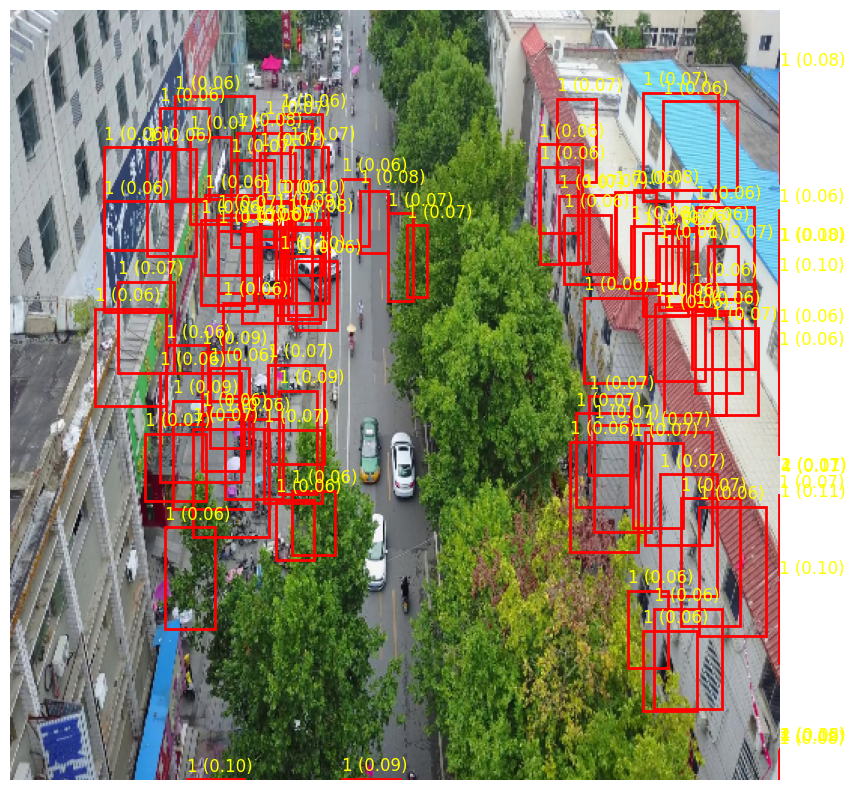

In [ ]:
# Function to visualize the output predicitons made by the model

def show_prediction(img_tensor, pred, label_map=None, score_thresh=0.5):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()  # [H, W, C]
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img)

    boxes = pred['boxes'].cpu()
    labels = pred['labels'].cpu()
    scores = pred['scores'].cpu()

    # Print prediction info
    print("Prediction Summary:")
    print(f"  Total predictions: {len(boxes)}")
    print(f"  Scores: {scores}")
    print(f"  Boxes: {boxes}")
    print(f"  Labels: {labels}")

    has_detections = False

    # Visualize each bounding box using patches package and plt

    for box, label, score in zip(boxes, labels, scores):
        if score < score_thresh:
            continue
        has_detections = True
        x1, y1, x2, y2 = box
        width, height = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        label_str = f"{label}"
        if label_map and label in label_map:
            label_str = label_map[label]
        ax.text(x1, y1 - 5, f"{label_str} ({score:.2f})", color='yellow', fontsize=12)

    if not has_detections:
        print(f"No predictions above threshold ({score_thresh})")

    plt.axis('off')
    plt.show()


In [ ]:
show_prediction(images[0], outputs[0], label_map=label_map, score_thresh=0.05)

In [ ]:
# Model Evaluation:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

iou_threshold=0.5
confidence_threshold=0.5

# Initialize mAP metric from torchmetrics
map_metric = MeanAveragePrecision()

all_preds = []
all_gts = []

# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    for images, targets in tqdm(test_loader, desc="Evaluating"):
        # Move data to device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        preds = model(images)

        # Update mAP metric
        map_metric.update(preds, targets)

        # Collect predictions and ground truth labels for precision/recall/F1
        for pred, tgt in zip(preds, targets):
            pred_boxes = pred['boxes']
            pred_labels = pred['labels']
            pred_scores = pred['scores']

            gt_boxes = tgt['boxes']
            gt_labels = tgt['labels']

            # Filter predictions based on confidence score
            valid_preds = pred_scores > confidence_threshold
            pred_boxes = pred_boxes[valid_preds]
            pred_labels = pred_labels[valid_preds]

            # Match predictions to ground truth using IoU threshold
            ious = box_iou(pred_boxes, gt_boxes)
            matched_gt_indices = torch.argmax(ious, dim=1)

            # Only keep predictions that have at least one match with ground truth
            for i, pred_label in enumerate(pred_labels):
                if ious[i, matched_gt_indices[i]] > iou_threshold:
                    all_preds.append(pred_label.item())
                    all_gts.append(gt_labels[matched_gt_indices[i]].item())
# Compute mAP
map_metrics = map_metric.compute()

In [ ]:
print(f"mAP (0.50:0.95): {map_metrics['map']:.8f}")
print(f"mAP@0.50:        {map_metrics['map_50']:.8f}")
print(f"mAP@0.75:        {map_metrics['map_75']:.8f}")
print(f"mAP (small):     {map_metrics['map_small']:.8f}")
print(f"mAP (medium):    {map_metrics['map_medium']:.8f}")
print(f"mAP (large):     {map_metrics['map_large']:.8f}")

# Compute Precision, Recall, and F1 score for each class
classes = list(range(1, 13))
precision = precision_score(all_gts, all_preds, average=None, labels=classes)
recall = recall_score(all_gts, all_preds, average=None, labels=classes)
f1 = f1_score(all_gts, all_preds, average=None, labels=classes)

# Print out precision, recall, and F1 per class
for cls, p, r, f in zip(classes, precision, recall, f1):
    print(f"Class {cls:2d} → Precision: {p:.8f}, Recall: {r:.8f}, F1: {f:.8f}")